## Regression of Edmunds Consumer Car Dataset

Dataset Source: https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews

#### Import Necessary Libraries

In [1]:
import sys, os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'

import glob

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, set_seed, get_scheduler

from datasets import Dataset, DatasetDict

#### Display Versions of Relevant Libraries, Frameworks, Languages, etc. Used in This Project

In [2]:
print("Python Version:".rjust(18), sys.version[0:6])
print("NumPy Version:".rjust(18), np.__version__)
print("Pandas Version:".rjust(18), pd.__version__)
print("Torch Version:".rjust(18), torch.__version__)

   Python Version: 3.9.7 
    NumPy Version: 1.23.3
   Pandas Version: 1.4.4
    Torch Version: 1.12.1


### Data Ingestion & Preprocessing

#### Data Ingestion

In [3]:
data_folder = "/Users/leedunn/Desktop/Projects to Train/Edmunds Car Reviews/Car Brand Reviews"

all_files = glob.glob(os.path.join(data_folder, "*.csv"))

folder = '/Users/leedunn/Desktop/Projects to Train/Edmunds Car Reviews/Car Brand Reviews/Scraped_Car_Review_'

file_type=".csv"

fileset = [x for x in all_files]

df = pd.concat((pd.read_csv(f, on_bad_lines="skip", lineterminator='\n') for f in fileset), ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226931 entries, 0 to 226930
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     226931 non-null  int64  
 1   Review_Date    226931 non-null  object 
 2   Author_Name    226930 non-null  object 
 3   Vehicle_Title  226931 non-null  object 
 4   Review_Title   226918 non-null  object 
 5   Review         226931 non-null  object 
        226931 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 12.1+ MB


#### Data Preprocessing (Part 1)

In [4]:
# drop duplicate reviews
df.drop_duplicates(inplace=True)


# Features to drop, if they still are included in the dataframe
cols_to_check = ["Vehicle_Title", "Unnamed: 0", "Review_Date", "Author_Name", "level_0", "index"] 
cols_to_drop = []
for x in cols_to_check:
    if x in df.columns:
        cols_to_drop.append(x)

df.drop(columns=cols_to_drop, inplace=True)

# concatenate the review title and text and rename it to 'text' (use ' : ' as the seperator)
df["text"] = df["Review_Title"] + " : " + df["Review"]

# Since there are only 13 missing values (all of them are review titles) 
# out of 226,000+ samples, I am just going to drop those samples
review_title_feature = "Review_Title"
if review_title_feature in df.columns:
    df.dropna(axis=0, subset=[review_title_feature], inplace=True)

df

,Review_Title,Review,Rating\r,text
0,Great Car,I bought this car for my son and he loves it!...,5.000,Great Car : I bought this car for my son and ...
1,Lamborghini Murcielago Review,I love my Lamborghini Murcielago. It is a thr...,5.000,Lamborghini Murcielago Review : I love my Lam...
2,The sweetest car ever,This car is the greatest ever! I love drivin...,5.000,The sweetest car ever : This car is the great...
3,The #1 Lamborghini,I have owned both the Gallardo and the Murcie...,5.000,The #1 Lamborghini : I have owned both the Ga...
4,Lamboreport,This is one of the best cars ever built. It h...,5.000,Lamboreport : This is one of the best cars ev...
...,...,...,...,...
226926,A Perfect Sports Car!,I waited 686 days from the date I placed my d...,4.750,A Perfect Sports Car! : I waited 686 days fro...
226927,AM Vantage V8 is a winner,I have one of the first US Vantage V8s and it...,4.875,AM Vantage V8 is a winner : I have one of the...
226928,Finally...,An amazing car! Drove Porsches for the past 7...,4.750,Finally... : An amazing car! Drove Porsches f...
226929,N420 A Driver's Car,Recently took delivery of 2011 N420 roadster ...,4.875,N420 A Driver's Car : Recently took delivery ...


#### Data Preprocessing (Part 2)

In [5]:
ratings_col = "Rating\r"
if ratings_col in df.columns:
    df["Rating\r"] = df["Rating\r"].astype(float)
    df.rename(columns={"Rating\r" : "label"}, inplace=True)


# Drop Unused Features
cols_to_check = ["Review_Title", "Review"] 
cols_to_drop = []


for x in cols_to_check:
    if np.any(x in df.columns):
        if np.any("text" in df.columns):
            cols_to_drop.append(x)

df.drop(columns=cols_to_drop, inplace=True)

df

,label,text
0,5.000,Great Car : I bought this car for my son and ...
1,5.000,Lamborghini Murcielago Review : I love my Lam...
2,5.000,The sweetest car ever : This car is the great...
3,5.000,The #1 Lamborghini : I have owned both the Ga...
4,5.000,Lamboreport : This is one of the best cars ev...
...,...,...
226926,4.750,A Perfect Sports Car! : I waited 686 days fro...
226927,4.875,AM Vantage V8 is a winner : I have one of the...
226928,4.750,Finally... : An amazing car! Drove Porsches f...
226929,4.875,N420 A Driver's Car : Recently took delivery ...


#### Visulatization: Distribution of

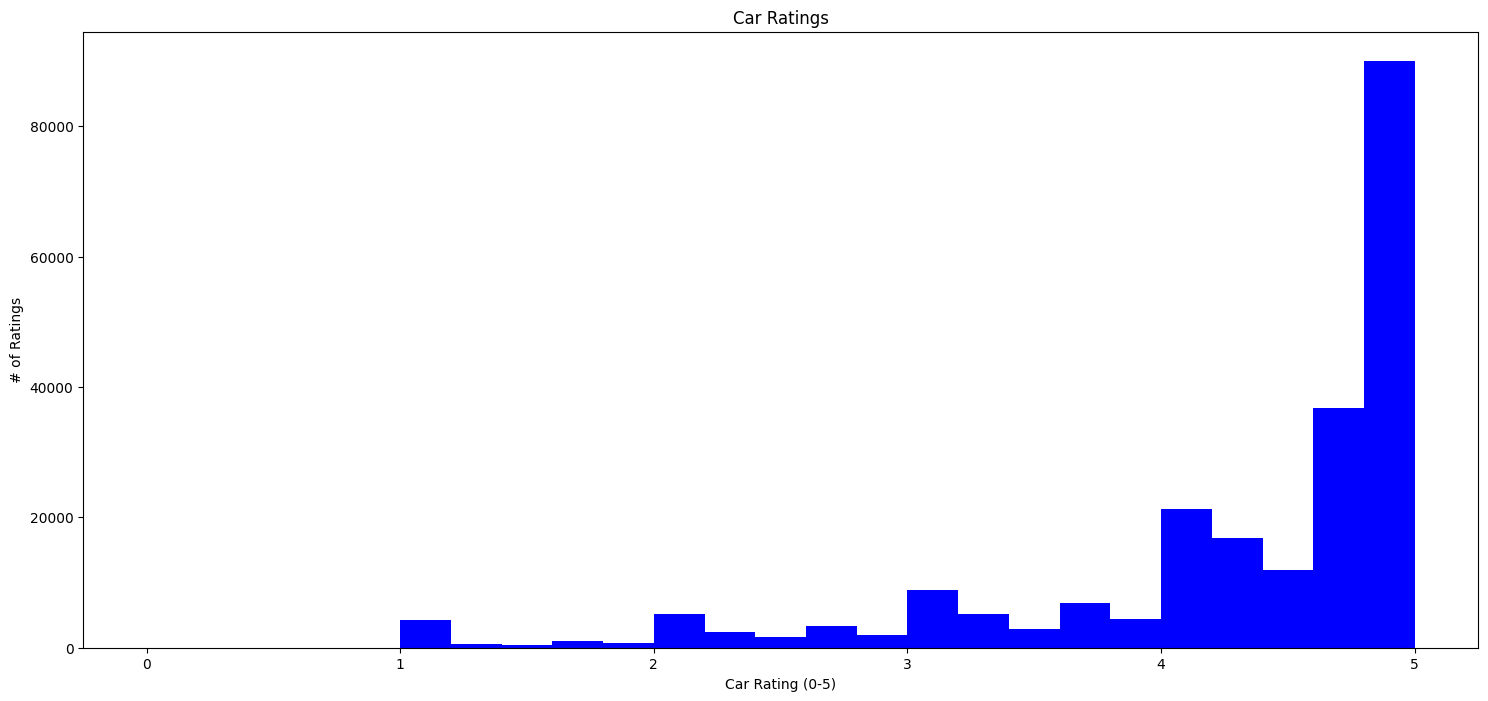

In [6]:
df.hist("label", color="Blue", grid=False, bins=25, figsize=(18,8), range=(0,5))
plt.suptitle('')
plt.title('Car Ratings')
plt.xlabel('Car Rating (0-5)')
plt.ylabel('# of Ratings')
plt.show()

#### Visualiation of Input Length

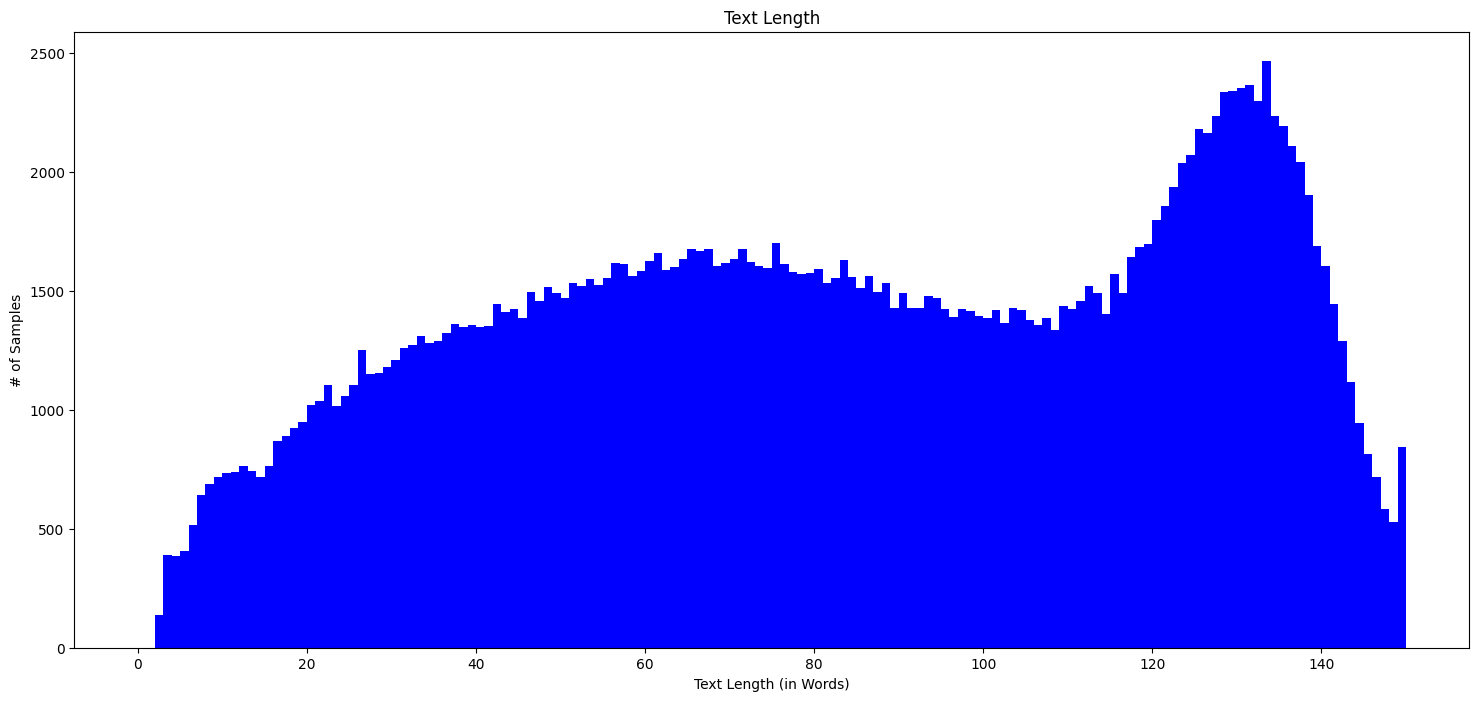

In [7]:
df['Text Length'] = df['text'].str.split().apply(len)

n = 150
df.hist("Text Length", color="Blue", grid=False, bins=n, range=(0,n), figsize=(18,8))
plt.suptitle('')
plt.xlabel('Text Length (in Words)')
plt.ylabel('# of Samples')
plt.show()

#### Drop Unnecessary Features & Trim Overly Lengthy Reviews

In [8]:
df = df[df["Text Length"] < 146]

df.drop(columns=["Text Length"], inplace=True)
df.count()

/var/folders/vb/6w_1xfss7_zgtx5g93jlj0z80000gn/T/ipykernel_31822/363466532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Text Length"], inplace=True)


label    207313
text     207313
dtype: int64

### Actual Project

#### Convert Pandas DataFrame to Datasets

In [9]:
dataset = Dataset.from_pandas(df)

#### Split Dataset into Training & Testing Dataset

In [10]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (165850, 3)
Testing data shape: (20732, 3)
Eval data shape: (20731, 3)


##### Basic Values

In [11]:
NUM_OF_EPOCHS = 2
MAX_INPUT_LEN = int(round(150*1.3, 0))

MODEL_CKPT = "distilbert-base-uncased"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_LABELS = 1
BATCH_SIZE = 64

MODEL_NAME = f"{MODEL_CKPT}-Regression-Edmunds_Car_Reviews-all_car_brands"
LEARNING_RATE = 1.5e-5

set_seed(42)

#### HuggingFace Access Token & Install git lfs

In [12]:
# HuggingFace Access Token ... 

!git lfs install

Git LFS initialized.


#### Tokenize Entire Dataset

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=MAX_INPUT_LEN, return_tensors="np")

encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Print Example to Ensure Edits Worked As Expected

In [14]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'label': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', 'text', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 165850
})


#### Initialize Model

In [15]:
model = (AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=NUM_LABELS)).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

#### Metrics Evaluation Function

In [16]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
        
    return {"mse": mse, "rmse": rmse, "mae": mae}

#### Trainer Arguments

In [17]:
training_args = TrainingArguments(output_dir=MODEL_NAME, 
                                  num_train_epochs=NUM_OF_EPOCHS, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=LEARNING_RATE,
                                  no_cuda=True,
                                  evaluation_strategy='epoch',
                                  save_total_limit=10,
                                  logging_strategy='epoch',
                                  load_best_model_at_end=True,
                                  disable_tqdm=False,
                                  metric_for_best_model='mae',
                                  greater_is_better=False,
                                  save_strategy='epoch',
                                  push_to_hub=True)

####  Build Trainer

In [18]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics_for_regression)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands into local empty directory.


#### Train Trainer

In [19]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 165850
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 5184


  0%|          | 0/5184 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


{'loss': 0.3936, 'learning_rate': 7.5e-06, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 20731
  Batch size = 64


  0%|          | 0/324 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-2592
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-2592/config.json


{'eval_loss': 0.22821131348609924, 'eval_mse': 0.22821131348609924, 'eval_rmse': 0.4777146875858307, 'eval_mae': 0.31577789783477783, 'eval_runtime': 5778.3056, 'eval_samples_per_second': 3.588, 'eval_steps_per_second': 0.056, 'epoch': 1.0}


Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-2592/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-2592/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-2592/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


{'loss': 0.2163, 'learning_rate': 0.0, 'epoch': 2.0}


***** Running Evaluation *****
  Num examples = 20731
  Batch size = 64


  0%|          | 0/324 [00:00<?, ?it/s]

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-5184
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-5184/config.json


{'eval_loss': 0.2159704864025116, 'eval_mse': 0.2159704864025116, 'eval_rmse': 0.4647262394428253, 'eval_mae': 0.31062051653862, 'eval_runtime': 5719.868, 'eval_samples_per_second': 3.624, 'eval_steps_per_second': 0.057, 'epoch': 2.0}


Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-5184/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-5184/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-5184/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/checkpoint-5184 (score: 0.31062051653862).


{'train_runtime': 403870.5811, 'train_samples_per_second': 0.821, 'train_steps_per_second': 0.013, 'train_loss': 0.3049432495493948, 'epoch': 2.0}


TrainOutput(global_step=5184, training_loss=0.3049432495493948, metrics={'train_runtime': 403870.5811, 'train_samples_per_second': 0.821, 'train_steps_per_second': 0.013, 'train_loss': 0.3049432495493948, 'epoch': 2.0})

### Evaluate Model

#### Generate Predictions

In [20]:
trainer.eval_dataset = encoded_ds['test']
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 20732
  Batch size = 64


  0%|          | 0/324 [00:00<?, ?it/s]

{'eval_loss': 0.2231525331735611,
 'eval_mse': 0.2231525331735611,
 'eval_rmse': 0.47239023447036743,
 'eval_mae': 0.3150399327278137,
 'eval_runtime': 5689.4923,
 'eval_samples_per_second': 3.644,
 'eval_steps_per_second': 0.057,
 'epoch': 2.0}

#### Push Model to Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Edmunds_Car_Reviews-all_car_brands
   0c98f97..d7420f9  main -> main

